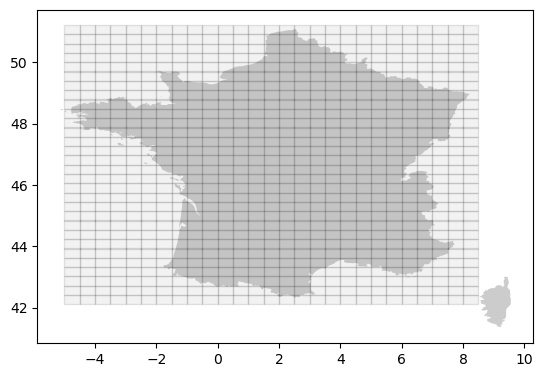

In [1]:
import pandas as pd
from shapely import Point, Polygon
from dataclasses import dataclass
import numpy as np
from matplotlib import animation
import os
import seaborn as sns
import geopandas as gpd
from matplotlib import pyplot as plt   
import warnings 

warnings.filterwarnings("ignore")

def show_on_map(ax=None):
    france = gpd.read_file(r"C:\Subpbiotech_cours\BT4\iGEM\Dry_lab\Model_prediction\EDA_1\Data\shapefile\FRA_adm0.shp")

    france.plot(ax=ax,alpha=0.4, color='grey')
    gdf_grid.plot(ax=ax, alpha = 0.1, color = "gray", edgecolor="black", )

xs, xe, ys, ye = -4.5, -5, 41.80357, 42.11314
grid = []
for j in range(0, 30):
    ys += 0.30357
    ye += 0.30357
    for i in range(0, 27):
        grid.append(Polygon(
            (Point(xs, ys), Point(xs, ye), Point(xe, ye), Point(xe, ys))
        ))
        xs += 0.5
        xe += 0.5
    xs = -4.5
    xe = -5

gdf_grid = gpd.GeoDataFrame({"geometry": grid})
fig = plt.figure(1)
ax1 = fig.subplots(1,1)
#show_on_map(ax1)
os.chdir(r"C:\Subpbiotech_cours\BT4\iGEM\Dry_lab\Model_prediction\weather_data")

df = pd.read_csv("France_temp_2000_2022.csv", sep=',')

df_position = df.drop_duplicates(subset=["NOM_USUEL"], keep='first')
all_lat = [lat for lat in df_position["LAT"]]
all_lon = [lon for lon in df_position["LON"]]

all_stations_points = [Point(all_lon[point], all_lat[point]) for point in range(0, len(all_lat))]
df_position["STATIONS_XY"] = all_stations_points

dico_station_position = dict(zip(df_position["NOM_USUEL"], df_position["STATIONS_XY"]))
@dataclass
class Station:
    nom : str
    position : Point
    def __init__(self, nom, position):
        self.nom = nom
        self.position = position

all_Stations = [Station(nom, position) for nom, position in dico_station_position.items()]

@dataclass
class Case:
    id:int
    position:Polygon
    contain_station:list
    name_station:list
    neighbour:list
    frame_by_year:dict
    a : float
    b : float
    c : float
    slope : float
    intercept : float

    def __init__(self, id, position, contain_station, name_stations, frame, neighbour, frame_by_year, a, b, c, slope, intercept):
        self.id = id
        self.position = position
        self.contain_station = contain_station
        self.name_station = name_stations
        self.frame = frame
        self.neighbour = neighbour
        self.frame_by_year = frame_by_year
        self.a = a
        self.b = b
        self.c = c
        self.slope = slope
        self.intercept = intercept

all_Cases = [Case(index, polygone, [], [], pd.DataFrame(), [], {}, -1, -1, -1, -1, -1) for index, polygone in enumerate(grid)]
def contains_station(container):    
    return [station for station in all_Stations if station.position.within(container["geometry"].values)]

neighbour_rule_index = [27, -27, -1, +1, 28, -28, 26, -26]

for case in all_Cases:
    temp = gpd.GeoDataFrame({"geometry":[case.position]})
    case.contain_station = contains_station(temp) #check if the station is in the case

valid_id = [case.id for case in all_Cases]

all_Cases = [Case(case.id, case.position, case.contain_station,
                  [nom.nom for nom in case.contain_station], pd.DataFrame(),
                  [case.id+i for i in neighbour_rule_index if case.id+i in valid_id], {}, -1, -1, -1, -1, -1) for case in all_Cases if case.contain_station != []]

os.chdir(r"C:\Subpbiotech_cours\BT4\iGEM\Dry_lab\Model_prediction\weather_data\square_csv")

def csv_to_square(liste_cases):
    for case in liste_cases:
        case.frame = pd.read_csv(f"{case.id}.csv", sep=',')
        case.frame = case.frame.drop(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0'], axis=1)
        case.frame = case.frame.sort_values('AAAAMMJJ')

    return liste_cases

all_Cases = csv_to_square(all_Cases)

## Separate frames by year

In [2]:
biss = [2000, 2004, 2008, 2012, 2016, 2020]
tot = 0
intervals = []
for date in range(2000, 2023):
    if date in biss:
        intervals.append((tot, tot+365))
        tot+=366
    else:
        intervals.append((tot, tot+364))
        tot+=365

n_days = dict(zip(range(2000, 2023), intervals))

print(n_days)
def date_frame_creation(cases : list)->list:
    for case in cases:
        new_frame = {key:pd.DataFrame() for key in range(2000,2023)}
        for col in new_frame.keys():
            start = n_days[col][0]
            end = n_days[col][1]
            new_frame[col] = case.frame[case.frame["AAAAMMJJ"].between(start, end)]

        case.frame_by_year = new_frame
    return cases
    
all_Cases = date_frame_creation(all_Cases)
print(all_Cases[0])

{2000: (0, 365), 2001: (366, 730), 2002: (731, 1095), 2003: (1096, 1460), 2004: (1461, 1826), 2005: (1827, 2191), 2006: (2192, 2556), 2007: (2557, 2921), 2008: (2922, 3287), 2009: (3288, 3652), 2010: (3653, 4017), 2011: (4018, 4382), 2012: (4383, 4748), 2013: (4749, 5113), 2014: (5114, 5478), 2015: (5479, 5843), 2016: (5844, 6209), 2017: (6210, 6574), 2018: (6575, 6939), 2019: (6940, 7304), 2020: (7305, 7670), 2021: (7671, 8035), 2022: (8036, 8400)}
Case(id=15, position=<POLYGON ((3 42.107, 3 42.417, 2.5 42.417, 2.5 42.107, 3 42.107))>, contain_station=[Station(nom='SERRALONGUE', position=<POINT (2.558 42.4)>)], name_station=['SERRALONGUE'], neighbour=[42, 14, 16, 43, 41], frame_by_year={2000:      AAAAMMJJ   TN    TX  TM     TNTXM  TAMPLI
0         0.0  0.0  14.0 NaN  5.833333    14.0
1         1.0  1.0  12.0 NaN  6.500000    11.0
2         2.0  1.5  11.5 NaN  6.500000    10.0
3         3.0  0.0  14.0 NaN  7.000000    14.0
4         4.0 -1.5  12.0 NaN  5.300000    13.5
..        ...  

We paired meteorological stations with suction-traps (Appendix S1c) and derived accumulated degree days above 16 °C for each site-year or for first flight site-year-period (i.e. April-May) **[Σ (daily average temperatures – 16 °C)]**. The lowest known threshold that will allow the initiation of aphid flight is **11 °C,** but clearly this is not appropriate for this study as it will incur false-positive flight days as many species' thresholds are much higher. Consequently, we adopt the upper level cited by Irwin, Kampmeier & Weisser (2007) of **16 °C**

In [4]:
def added_temp_calc(cases : list) -> pd.DataFrame:
    ad_temp_frame = pd.DataFrame(index=[str(i) for i in range(2000, 2023)], columns=[case.id for case in all_Cases])
    temp = 0
    for case in all_Cases:
        for year, frame in case.frame_by_year.items():
            tresh = 5
            add = 0
            for day in frame["AAAAMMJJ"].values:
                temp = frame["TNTXM"].loc[frame["AAAAMMJJ"]==day].values[0]
                if temp < 0 or temp-tresh < 0 :
                    continue               

                if temp-tresh > 0:
                    add += temp-tresh
                if add > tresh:
                    if temp > 16 :
                        break
            if add < 5 :
                ad_temp_frame[case.id][str(year)] = -1
            else:
                ad_temp_frame[case.id][str(year)] = day - n_days[year][0]
    
    return ad_temp_frame

tresh_date = added_temp_calc(all_Cases)


for col in tresh_date.columns:
    if -1 in tresh_date[col].values:
        tresh_date = tresh_date.drop(col, axis=1)

tresh_date

15      91.826087
40     138.565217
41     123.434783
42      44.826087
43       57.26087
          ...    
769         117.0
770    112.434783
771    118.434783
796    122.304348
797    109.913043
Length: 449, dtype: object

In [5]:
from sklearn.metrics import mean_squared_error

def sine(Y_pred, dico_pred, Y, X, a, b, c):
    slope = (Y_pred[10]-Y_pred[0])/(X[10]-X[0])

    dico_temp = dict(zip(np.arange(2000, 2023, 0.1), dico_pred))

    x = np.arange(2000, 2023, 0.1)

    y = a*np.sin(b*x + c) 

    d = [dico_temp[i]+slope for i in x]
    y = [y[index] + elt for index, elt in enumerate(d)]

    x = [round(i, 1) for i in x]
    y_values = dict(zip(x, y))
    y_sinpred = [y_values[float(date)][0] for date in tresh_date.index]

    RMSE_SR = np.sqrt(mean_squared_error(Y, y_sinpred))

    return RMSE_SR, x, y, (a,b,c,slope)

import itertools
import time as t

start = t.time()
def combinations(a:list, b:list, c:list):
    return list(itertools.product(*[a, b, c]))
    
print(len(combinations(range(0, 100), range(10, 200), range(20, 300))))

end = t.time()

print(end-start)


5320000
0.4335441589355469


0
RMSE LR : 24.414624241592232
RMSE SR : 19.515256422398906
(21, 170, 6, array([4.51457363]), -8943.840394408926)


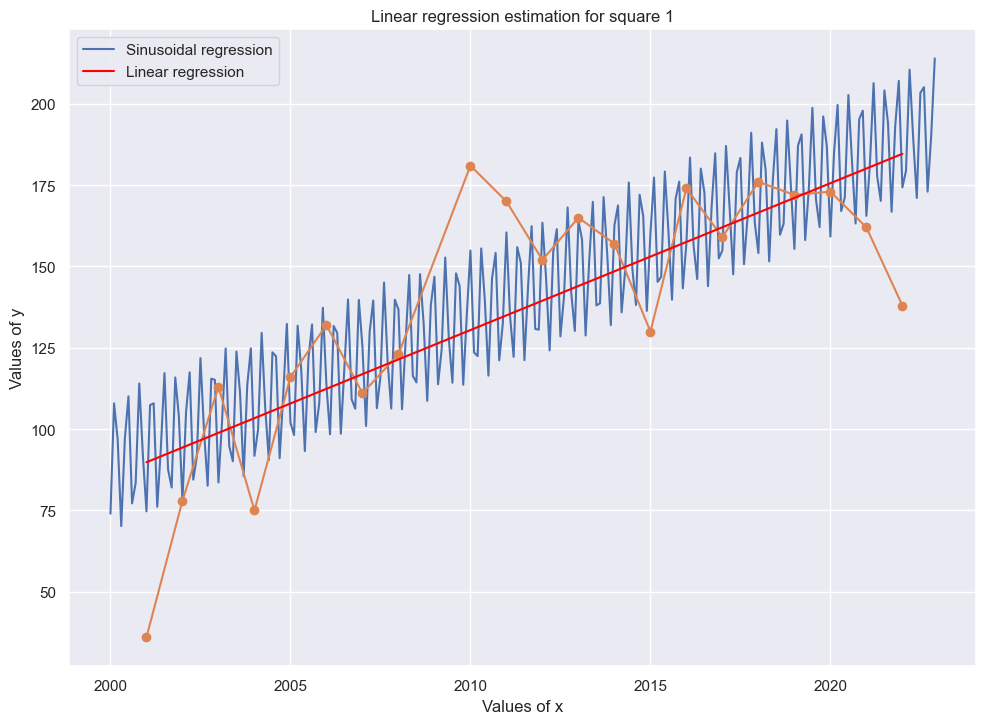

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import math as m

sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

from sklearn.metrics import mean_squared_error

def sine(Y_pred, dico_pred, Y, X, a, b, c, intercept):
    slope = (Y_pred[10]-Y_pred[0])/(X[10]-X[0])

    dico_temp = dict(zip(np.arange(2000, 2023, 0.1), dico_pred))

    x = np.arange(2000, 2023, 0.1)

    y = a*np.sin(b*x + c) 

    d = [dico_temp[i]+slope for i in x]
    y = [y[index] + elt for index, elt in enumerate(d)]

    x = [round(i, 1) for i in x]
    y_values = dict(zip(x, y))
    y_sinpred = [y_values[date[0]][0] for date in X]

    RMSE_SR = np.sqrt(mean_squared_error(Y, y_sinpred))
    r2_SR = r2_score(Y, y_sinpred)

    return RMSE_SR, x, y, (a,b,c,slope, intercept), r2_SR, y_sinpred

import itertools
import time as t

def combinations(a:list, b:list, c:list):
    return list(itertools.product(*[a, b, c]))

# b = number of periods ==> number of years, should not be changing
# a is the amplitude ==> parameter to be found
# c is the displacement applied to the graph ==> 0
# d is the median sinus line ==> equivalent to the linear regression predicted

def base_line(tresh_date):
    LR_score = []
    SR_score = []
    all_param = []
    for index, col in enumerate(tresh_date.columns):
        best_param_ = ()
        best_score_ = 1000
        x = []
        y = []
        df = pd.DataFrame({"year":tresh_date.index, "day":tresh_date[col].values})
        df = df.drop(df['day'].idxmax())
        df = df.drop(df['day'].idxmin())
        df["year"] = df["year"].astype(int)

        X = df.drop("day", axis=1).values
        Y = df["day"]

        mean_Y = np.mean(Y)
        sd_Y = np.std(Y)

        norm_Y_pred = np.random.normal(mean_Y, sd_Y, len(Y))

        RMSE_norm = np.sqrt(mean_squared_error(Y, norm_Y_pred))
        r2_norm = r2_score(Y, norm_Y_pred)

        LR = LinearRegression()
        LR.fit(X, Y)

        test = [LR.coef_[0]*i+LR.intercept_ for i in range(2000, 2023)]

        Y_pred = LR.predict(X)

        RMSE_LR = np.sqrt(mean_squared_error(Y, Y_pred))
        r2_LR = r2_score(Y, Y_pred)

        predX = np.arange(2000, 2023, 0.1).reshape(-1, 1)
        dico_pred = LR.predict(predX)

        param_grid = combinations(np.arange(-30, 30, 1), np.arange(160, 180, 1), np.arange(-10,10, 1))

        dico_param_score = {param : sine(Y_pred, dico_pred, Y, X, param[0], param[1], param[2], LR.intercept_) for param in param_grid}

        for key, value in dico_param_score.items():
            if value[0] < best_score_:
                best_score_ = value[0]
                x = value[1]
                y = value[2]
                best_param_ = value[3]
                r2_SR = value[4] 
                y_sinpred = value[5]

        LR_score.append(RMSE_LR)
        SR_score.append(best_score_)
        all_param.append(best_param_)

        print(index)
        
        print(f"RMSE LR : {RMSE_LR}")
        print(f"RMSE SR : {best_score_}")
        print(best_param_)

        plt.plot(x, y, label="Sinusoidal regression")

        #plt.scatter(range(2000, 2023), y_sinpred, label='Sinus prediction', color ="black")

        plt.plot([i[0] for i in X], Y, marker='o')
        plt.plot([i[0] for i in X], Y_pred, color='red', label='Linear regression')          
        plt.title("Linear regression estimation for square 1")
        plt.xlabel("Values of x")   
        plt.ylabel("Values of y")
        plt.legend()
        return 
    
    plt.plot(range(0, len(LR_score)), LR_score, marker='o', color='b')
    plt.plot(range(0, len(SR_score)), SR_score, marker='o', color='r')
    plt.show()
    return

    print(np.mean(LR_score), np.mean(SR_score))

    df = pd.DataFrame(columns=tresh_date.columns, index=["LR_score", "SR_score", "a", "b", "c", "slope", "intercept"])

    df.loc["LR_score"] = LR_score
    df.loc["SR_score"] = SR_score
    df.loc["a"] = [param[0] for param in all_param]
    df.loc["b"] = [param[1] for param in all_param]
    df.loc["c"] = [param[2] for param in all_param]
    df.loc["slope"] = [param[3][0] for param in all_param]
    df.loc["intercept"] = [param[4] for param in all_param]

    df.to_csv("score_param_temperature_final.csv")

    return df
    
base_line(tresh_date)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import math as m

sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

from sklearn.metrics import mean_squared_error

def sine(Y_pred, dico_pred, Y, X, a, b, c, intercept):
    slope = (Y_pred[10]-Y_pred[0])/(X[10]-X[0])

    dico_temp = dict(zip(np.arange(2000, 2023, 0.1), dico_pred))

    x = np.arange(2000, 2023, 0.1)

    y = a*np.sin(b*x + c) 

    d = [dico_temp[i]+slope for i in x]
    y = [y[index] + elt for index, elt in enumerate(d)]

    x = [round(i, 1) for i in x]
    y_values = dict(zip(x, y))
    y_sinpred = [y_values[float(date)][0] for date in tresh_date.index]

    RMSE_SR = np.sqrt(mean_squared_error(Y, y_sinpred))
    r2_SR = r2_score(Y, y_sinpred)

    return RMSE_SR, x, y, (a,b,c,slope, intercept), r2_SR, y_sinpred

import itertools
import time as t

def combinations(a:list, b:list, c:list):
    return list(itertools.product(*[a, b, c]))

# b = number of periods ==> number of years, should not be changing
# a is the amplitude ==> parameter to be found
# c is the displacement applied to the graph ==> 0
# d is the median sinus line ==> equivalent to the linear regression predicted

def base_line(tresh_date):
    LR_score = []
    SR_score = []
    all_param = []
    for index, col in enumerate(tresh_date.columns):
        best_param_ = ()
        best_score_ = 1000
        x = []
        y = []
        df = pd.DataFrame({"year":tresh_date.index, "day":tresh_date[col].values})
        df["year"] = df["year"].astype(int)

        X = df.drop("day", axis=1).values
        Y = df["day"]

        mean_Y = np.mean(Y)
        sd_Y = np.std(Y)

        norm_Y_pred = np.random.normal(mean_Y, sd_Y, len(Y))

        RMSE_norm = np.sqrt(mean_squared_error(Y, norm_Y_pred))
        r2_norm = r2_score(Y, norm_Y_pred)

        LR = LinearRegression()
        LR.fit(X, Y)

        test = [LR.coef_[0]*i+LR.intercept_ for i in range(2000, 2023)]

        Y_pred = LR.predict(X)

        RMSE_LR = np.sqrt(mean_squared_error(Y, Y_pred))
        r2_LR = r2_score(Y, Y_pred)

        predX = np.arange(2000, 2023, 0.1).reshape(-1, 1)
        dico_pred = LR.predict(predX)

        param_grid = combinations(np.arange(7, 14.8, 0.1), np.arange(147, 152, 0.2), np.arange(0,5, 0.2))

        dico_param_score = {param : sine(Y_pred, dico_pred, Y, X, param[0], param[1], param[2], LR.intercept_) for param in param_grid}

        for key, value in dico_param_score.items():
            if value[0] < best_score_:
                best_score_ = value[0]
                x = value[1]
                y = value[2]
                best_param_ = value[3]
                r2_SR = value[4] 
                y_sinpred = value[5]

        LR_score.append(RMSE_LR)
        SR_score.append(best_score_)
        all_param.append(best_param_)

        print(index)
        
        """        
        plt.plot(x, y)

        plt.scatter(range(2000, 2023), y_sinpred, label='Sinus prediction', color ="black")

        plt.plot(range(2000, 2023), tresh_date[col].values, marker='o')
        plt.plot(range(2000, 2023), Y_pred, color='red')          
        plt.title("Sinusoidal Function")
        plt.xlabel("Values of x")   
        plt.ylabel("Values of y")
        plt.legend()"""
    
    plt.plot(range(0, len(LR_score)), LR_score, marker='o', color='b')
    plt.plot(range(0, len(SR_score)), SR_score, marker='o', color='r')
    plt.show()

    print(np.mean(LR_score), np.mean(SR_score))

    df = pd.DataFrame(columns=tresh_date.columns, index=["LR_score", "SR_score", "a", "b", "c", "slope", "intercept"])

    df.loc["LR_score"] = LR_score
    df.loc["SR_score"] = SR_score
    df.loc["a"] = [param[0] for param in all_param]
    df.loc["b"] = [param[1] for param in all_param]
    df.loc["c"] = [param[2] for param in all_param]
    df.loc["slope"] = [param[3][0] for param in all_param]
    df.loc["intercept"] = [param[4] for param in all_param]

    df.to_csv("score_param_temperature_final.csv")

    return df
    
base_line(tresh_date)

KeyboardInterrupt: 

14.218181818181789


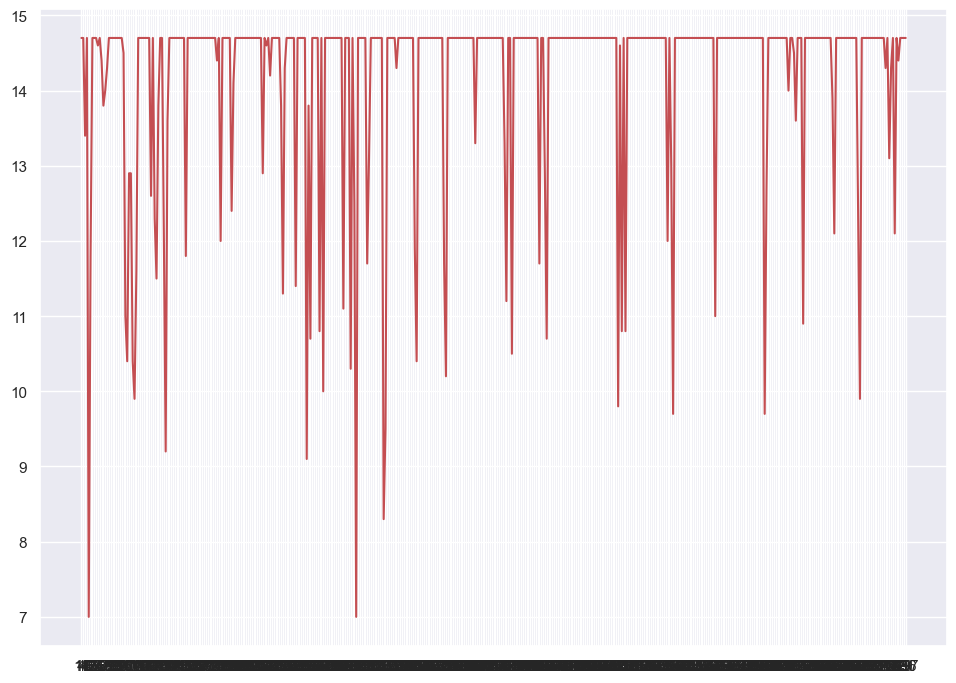

In [ ]:
def attribute_args(cases):
    df = pd.read_csv(r"C:\Subpbiotech_cours\BT4\iGEM\Dry_lab\Model_prediction\weather_data\square_csv\score_param_temperature_final.csv")
    df = df.drop("Unnamed: 0", axis=1)

    print(np.average(df.iloc[2].astype(float)))

    plt.plot(df.columns, df.iloc[2].astype(float), color='r')

attribute_args(all_Cases)


In [ ]:
import pandas as pd

df = pd.read_csv(r"C:\Subpbiotech_cours\BT4\iGEM\Dry_lab\Model_prediction\Avengers\data\cases_with_weather\cases_wstart.csv", index_col="Unnamed: 0")

df

,id,position,contain_station,name_station,neighbour,frame_by_year,a,b,c,slope,intercept
0,14,"POLYGON ((2.5 42.10714, 2.5 42.41671, 2 42.416...","[{'nom': 'PUIGMAL-NIVOSE', 'position': <POINT ...","['PUIGMAL-NIVOSE', 'PRATS-DE-MOLLO', 'COL D AR...","[41, 13, 15, 42, 40]",{},11.8,150.4,2.2,0.331028,-517.566206
1,15,"POLYGON ((3 42.10714, 3 42.41671, 2.5 42.41671...","[{'nom': 'ST LAURENT CERD', 'position': <POINT...","['ST LAURENT CERD', 'SERRALONGUE', 'LE TECH-EDF']","[42, 14, 16, 43, 41]",{},14.7,148.8,0.0,-0.343874,855.094862
2,37,"POLYGON ((0.5 42.41071, 0.5 42.72028, 0 42.720...","[{'nom': 'REF ESPUGUETTES', 'position': <POINT...",['REF ESPUGUETTES'],"[64, 10, 36, 38, 65, 9, 63, 11]",{},10.2,147.4,4.8,0.368577,-626.121542
3,38,"POLYGON ((1 42.41071, 1 42.72028, 0.5 42.72028...","[{'nom': 'MAUPAS-NIVOSE', 'position': <POINT (...",['MAUPAS-NIVOSE'],"[65, 11, 37, 39, 66, 10, 64, 12]",{},10.0,149.2,3.2,-0.095850,313.145257
4,40,"POLYGON ((2 42.41071, 2 42.72028, 1.5 42.72028...","[{'nom': 'RULHE', 'position': <POINT (1.726 42...","['RULHE', 'Ax Bonascre', 'HOSPITALET', 'L Hosp...","[67, 13, 39, 41, 68, 12, 66, 14]",{},13.9,151.0,0.6,-1.191700,2550.942688
...,...,...,...,...,...,...,...,...,...,...,...
472,770,"POLYGON ((2.5 50.60710000000002, 2.5 50.916670...","[{'nom': 'WATTEN', 'position': <POINT (2.213 5...","['WATTEN', 'NIELLES-LES-BLEQUIN_SAPC', 'ST-OMER']","[797, 743, 769, 771, 798, 742, 796, 744]",{},-1.0,-1.0,-1.0,-1.000000,-1.000000
473,771,"POLYGON ((3 50.60710000000002, 3 50.9166700000...","[{'nom': 'STEENVOORDE', 'position': <POINT (2....",['STEENVOORDE'],"[798, 744, 770, 772, 799, 743, 797, 745]",{},-1.0,-1.0,-1.0,-1.000000,-1.000000
474,772,"POLYGON ((3.5 50.60710000000002, 3.5 50.916670...","[{'nom': 'LILLE ISA', 'position': <POINT (3.04...","['LILLE ISA', 'ROUBAIX']","[799, 745, 771, 773, 800, 744, 798, 746]",{},-1.0,-1.0,-1.0,-1.000000,-1.000000
475,796,"POLYGON ((2 50.91067000000002, 2 51.2202400000...","[{'nom': 'CALAIS-MARCK', 'position': <POINT (1...",['CALAIS-MARCK'],"[769, 795, 797, 768, 770]",{},-1.0,-1.0,-1.0,-1.000000,-1.000000
